In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from peewee import *
from datetime import date, datetime
import matplotlib.dates as mdates
import re

In [40]:
db = MySQLDatabase('airfares', user='root', password='toor', host='localhost', autocommit=True)

In [42]:
class Airport(Model):
    airportCode = CharField(max_length=50, unique=True, index=True)
    airportName = CharField(max_length=255)
    city = CharField(max_length=255)
    country = CharField(max_length=255)

    class Meta:
        database = db

class Airline(Model):
    carrierCode = CharField(max_length=50, unique=True, index=True)
    carrierName = CharField(max_length=255)

    class Meta:
        database = db
        
class Flight(Model):
    flightKey = CharField(max_length=255, unique=True, index=True)
    flightNumber = CharField(max_length=50)
    departureDate = DateField()
    arrivalDate = DateField()
    departureTime = TimeField()
    arrivalTime = TimeField()
    journeyDuration = TimeField()
    totalNumberOfStops = IntegerField()
    carrierCode = ForeignKeyField(Airline, to_field='carrierCode', on_delete='CASCADE', on_update='CASCADE')
    depAirportCode = ForeignKeyField(Airport, to_field='airportCode', on_delete='CASCADE', on_update='CASCADE', backref='departures')
    arrAirportCode = ForeignKeyField(Airport, to_field='airportCode', on_delete='CASCADE', on_update='CASCADE', backref='arrivals')

    class Meta:
        database = db

class Price(Model):
    priceID = AutoField()
    flightKey = ForeignKeyField(Flight, to_field='flightKey', on_delete='CASCADE', on_update='CASCADE')
    scrapeDate = DateField()
    availableSeats = IntegerField()
    adultPrice = FloatField()

    class Meta:
        database = db



In [43]:
db.connect()
query1 = Flight.select().dicts()
query2 = Price.select().dicts()
query3 = Airport.select().dicts()
query4 = Airline.select().dicts()

flight_data = list(query1)
price_data = list(query2)
airport_data = list(query3)
airline_data = list(query4)

df_flight = pd.DataFrame(flight_data)
df_price = pd.DataFrame(price_data)
df_airport = pd.DataFrame(airport_data)
df_airline = pd.DataFrame(airline_data)
db.close()

True

In [44]:
df_flight

id                     flightKey flightNumber departureDate   
0        1  TB_OST_ALC_2023-04-09_TB1183       TB1183    2023-04-09  \
1        2  TB_BRU_ALC_2023-04-09_TB1111       TB1111    2023-04-09   
2        3  TB_ANR_ALC_2023-04-09_TB1101       TB1101    2023-04-09   
3        4  TB_ANR_ALC_2023-04-09_TB1103       TB1103    2023-04-09   
4        5  TB_ANR_ALC_2023-04-09_TB1105       TB1105    2023-04-09   
...    ...                           ...          ...           ...   
5531  5532  HV_BRU_IBZ_2023-09-18_HV9013       HV9013    2023-09-18   
5532  5533  HV_BRU_HER_2023-07-29_HV9211       HV9211    2023-07-29   
5533  5534  HV_BRU_HER_2023-08-15_HV9209       HV9209    2023-08-15   
5534  5535  HV_BRU_HER_2023-09-30_HV9211       HV9211    2023-09-30   
5535  5536  TB_BRU_TFS_2023-04-28_TB1751       TB1751    2023-04-28   

     arrivalDate departureTime arrivalTime journeyDuration   
0     2023-04-09      06:00:00    08:50:00        02:50:00  \
1     2023-04-09      06:10:00    08:55:00        02:45:00   
2     2023-04-09      08:30:00    11:15:00        02:45:00   
3     2023-04-09      14:05:00    16:45:00        02:40:00   
4     2023-04-09      15:20:00    18:00:00        02:40:00   
...          ...           ...         ...             ...   
5531  2023-09-18      17:40:00    20:05:00        02:25:00   
5532  2023-07-29      15:55:00    20:20:00        04:25:00   
5533  2023-08-15      06:35:00    11:00:00        04:25:00   
5534  2023-09-30      07:15:00    11:40:00        04:25:00   
5535  2023-04-28      06:05:00    10:05:00        05:00:00   

      totalNumberOfStops carrierCode depAirportCode arrAirportCode  
0                      0          TB            OST            ALC  
1                      0          TB            BRU            ALC  
2                      0          TB            ANR            ALC  
3                      0          TB            ANR            ALC  
4                      0          TB            ANR            ALC  
...                  ...         ...            ...            ...  
5531                   0          HV            BRU            IBZ  
5532                   0          HV            BRU            HER  
5533                   0          HV            BRU            HER  
5534                   0          HV            BRU            HER  
5535                   0          TB            BRU            TFS  

[5536 rows x 12 columns]

In [45]:
df_price

priceID                     flightKey  scrapeDate  availableSeats   
0             1  TB_OST_ALC_2023-04-09_TB1183  2023-04-07               5  \
1             2  TB_BRU_ALC_2023-04-09_TB1111  2023-04-07              -1   
2             3  TB_ANR_ALC_2023-04-09_TB1101  2023-04-07               9   
3             4  TB_ANR_ALC_2023-04-09_TB1103  2023-04-07               9   
4             5  TB_ANR_ALC_2023-04-09_TB1105  2023-04-07              -1   
...         ...                           ...         ...             ...   
100270   100271  HV_BRU_TFS_2023-09-16_HV9061  2023-04-26               5   
100271   100272  HV_BRU_TFS_2023-09-20_HV9061  2023-04-26              10   
100272   100273  HV_BRU_TFS_2023-09-23_HV9061  2023-04-26               8   
100273   100274  HV_BRU_TFS_2023-09-27_HV9061  2023-04-26               4   
100274   100275  HV_BRU_TFS_2023-09-30_HV9061  2023-04-26               1   

        adultPrice  
0           149.99  
1           129.99  
2            99.99  
3           129.99  
4            99.99  
...            ...  
100270      154.00  
100271      154.00  
100272      170.00  
100273      185.00  
100274      216.00  

[100275 rows x 5 columns]

### (1) Welke vliegtuigmaatschappij is gemiddeld de goedkoopste / de duurste?

##### Ryanair

In [6]:
ryanair_mean_price = df_price[df_price['flightKey'].isin(df_flight[df_flight['carrierCode'] == 'FR']['flightKey'])]['adultPrice'].mean()

##### Tui

In [7]:
tui_mean_price = df_price[df_price['flightKey'].isin(df_flight[df_flight['carrierCode'] == 'TB']['flightKey'])]['adultPrice'].median()

##### Transavia

In [8]:
transavia_mean_price = df_price[df_price['flightKey'].isin(df_flight[df_flight['carrierCode'] == 'HV']['flightKey'])]['adultPrice'].median()

<BarContainer object of 3 artists>

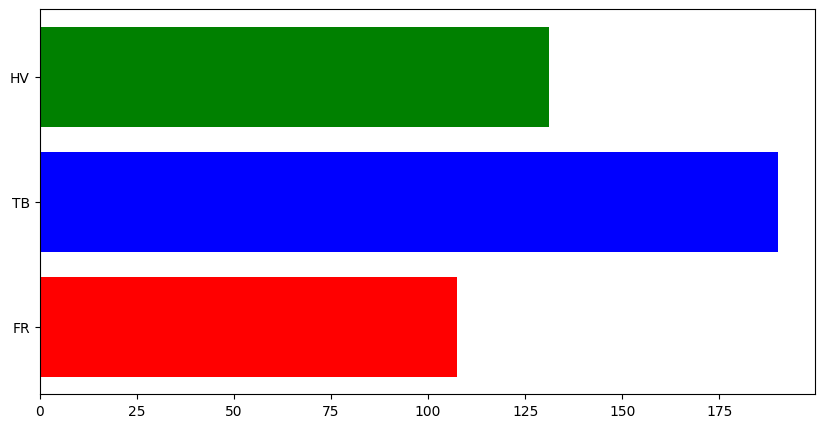

In [9]:
plt.figure(figsize=(10, 5))

carrier_codes = ['FR', 'TB', 'HV']
carrier_names = ['Ryanair', 'TUI', 'Transavia']

carrier_mean_prices = [ryanair_mean_price, tui_mean_price, transavia_mean_price]

colors = ['red', 'blue', 'green']

plt.barh(carrier_codes, carrier_mean_prices, color=colors)

### (8) Zijn de prijzen gerelateerd aan vakantieperiodes hier of ter plaatse?

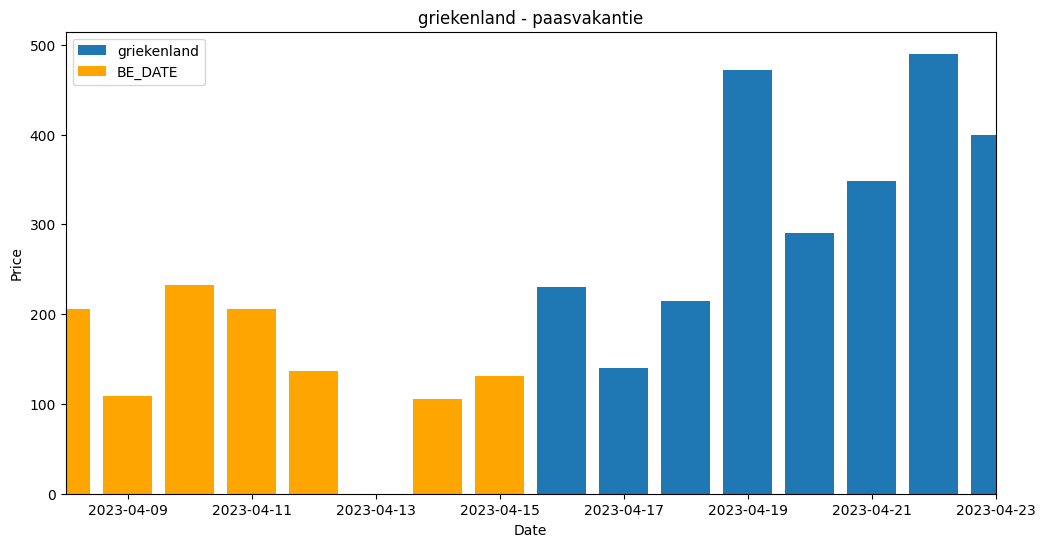

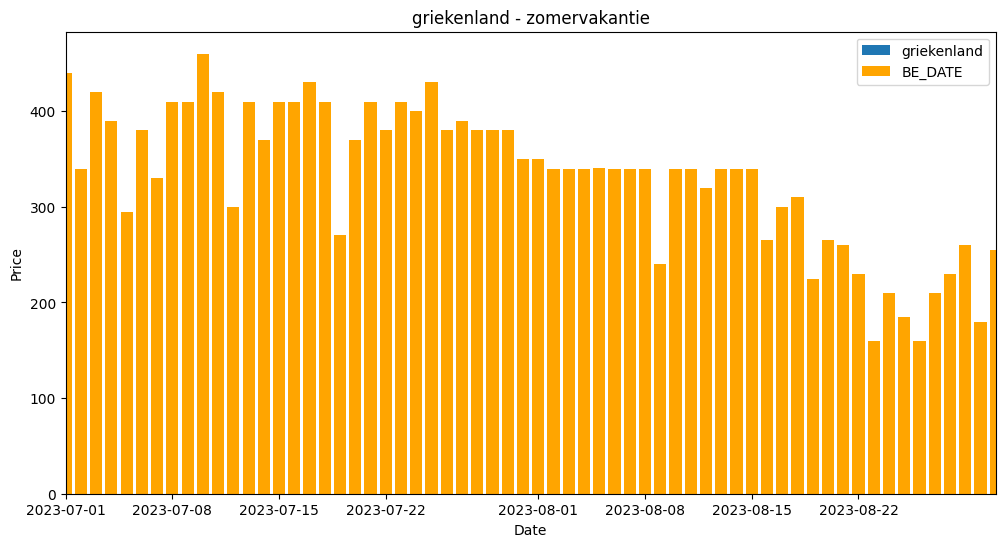

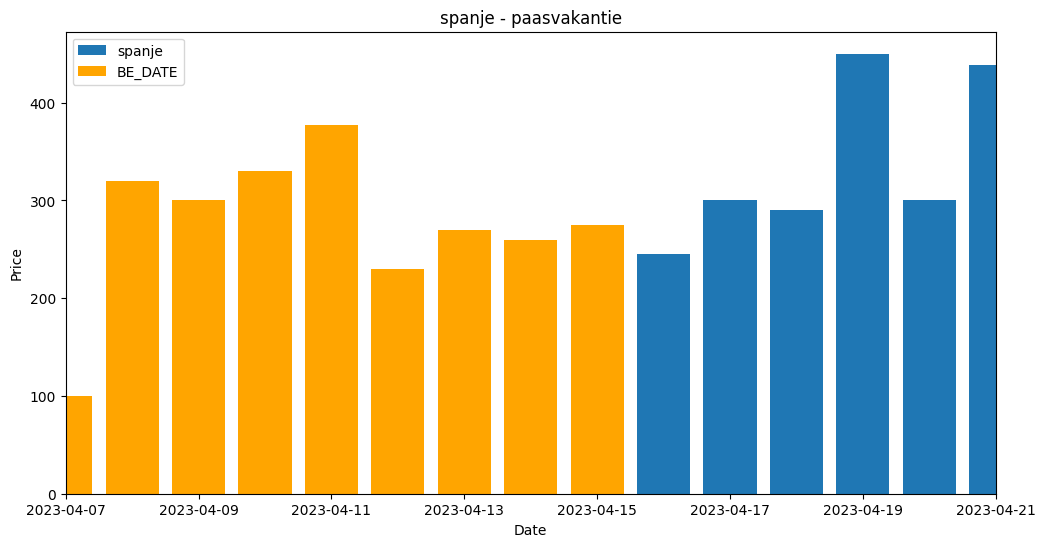

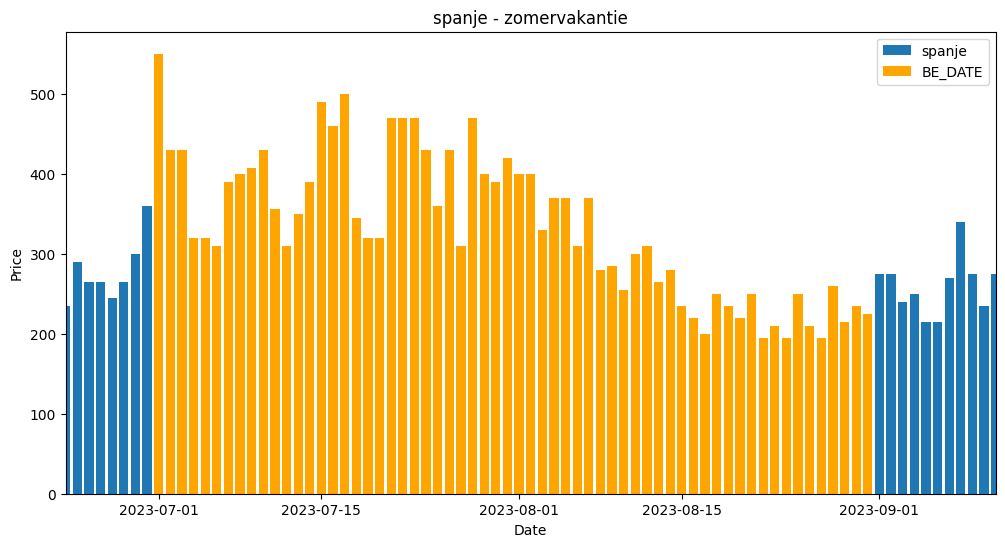

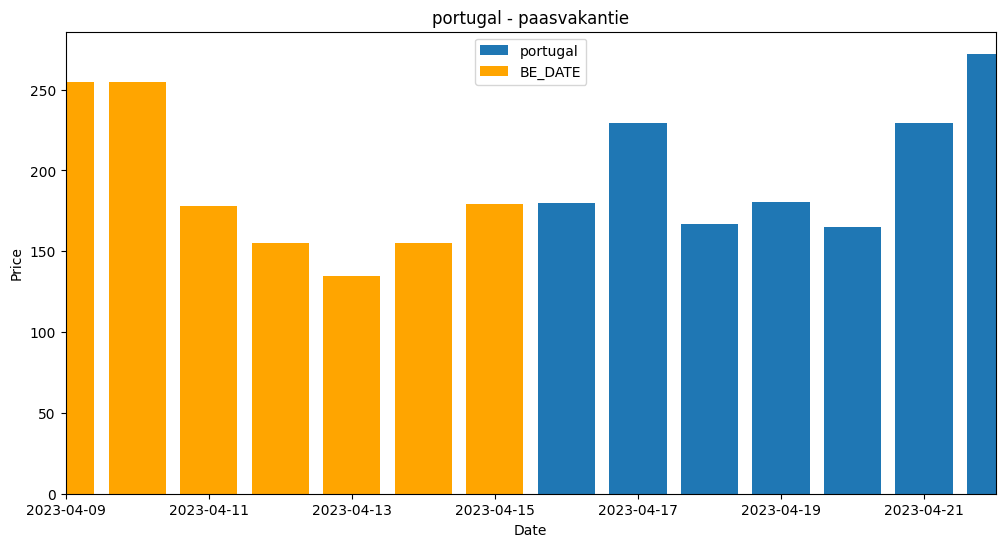

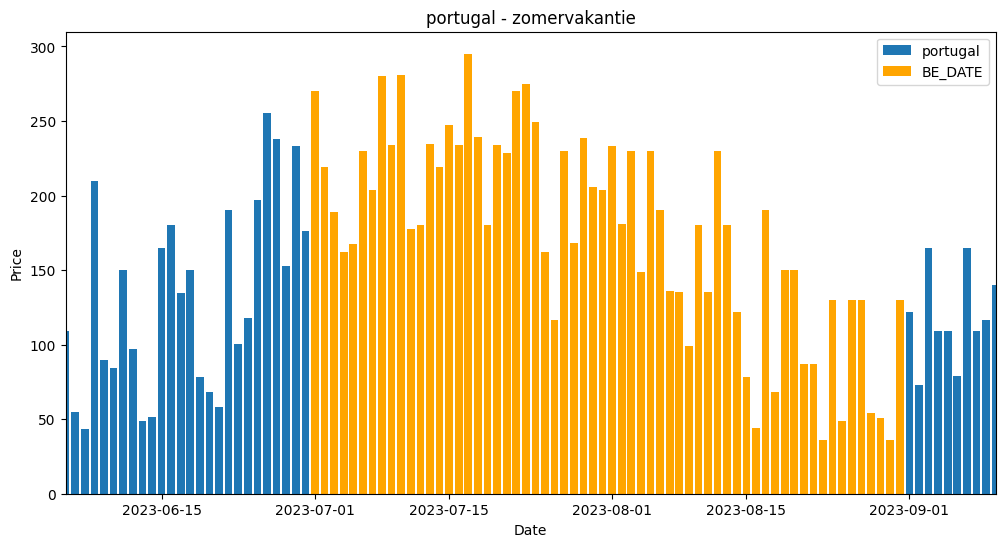

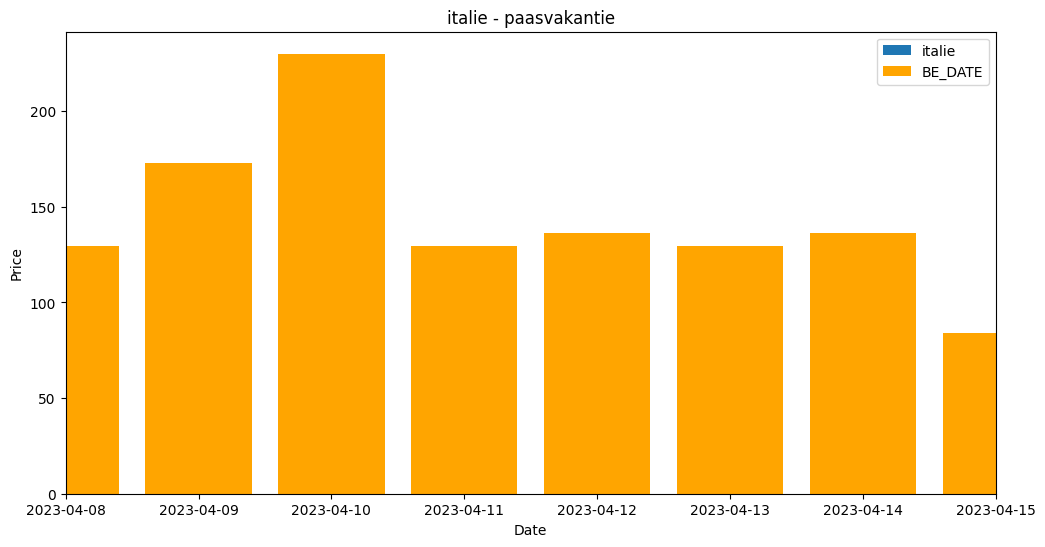

In [42]:
vakantie_periodes = {
    'griekenland': {
        'paasvakantie': ['2023-04-16', '2023-04-23'],
        'zomervakantie': ['2023-07-01', '2023-08-31'],
        'dvda': ['2023-05-01', '2023-05-01']
    }, 

    'spanje': {
        'paasvakantie': ['2023-04-04', '2023-04-21'],
        'zomervakantie': ['2023-06-23', '2023-09-11'],
        'dvda': ['2023-05-01', '2023-05-01']
    },

    'portugal': {
        'paasvakantie': ['2023-04-08', '2023-04-22'],
        'zomervakantie': ['2023-06-05', '2023-09-10'],
        'dvda': ['2023-05-01', '2023-05-01']
    },

    'italie': {
        'paasvakantie': ['2023-04-09', '2023-04-14'],
        'bevrijdingsdag': ['2023-04-25', '2023-04-25'],
        'zomervakantie': ['2023-06-08', '2023-09-17'],
        'dvda': ['2023-05-01', '2023-05-01'],
        'nationale_feestdag': ['2023-06-02', '2023-06-02']
    }
}

# 18 & 19 mei, 28 & 29 mei 

# hoogseizoen laagseizoen

def get_price_on_date(start_date, end_date):

    df = df_flight.merge(df_price, on='flightKey')

    df['arrivalDate'] = pd.to_datetime(df['arrivalDate'])

    df_filtered = df[(df['arrivalDate'] >= start_date) & (df['arrivalDate'] <= end_date)]

    # only keep adultPrice, arrivalDate, arrAirportCode, carrierCode, flightKey
    df_filtered = df_filtered[['adultPrice', 'arrivalDate', 'arrAirportCode', 'carrierCode']]

    return df_filtered

def plot_data(country, data, data_bel, period):
    # fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    # ax[0].set_title(f'{country} - {period}')
    # ax[0].set_xlabel('Date')
    # ax[0].set_ylabel('Price')
    # ax[0].bar(data['arrivalDate'], data['adultPrice'], label=f'{country}')
    # ax[0].legend()

    # ax[1].set_title(f'{country} - {period}')
    # ax[1].set_xlabel('Date')
    # ax[1].set_ylabel('Price')
    # ax[1].bar(data_bel['arrivalDate'], data_bel['adultPrice'], label='BE_DATE', color='orange')
    # ax[1].legend()

    # min_date = min(min(data['arrivalDate']), min(data_bel['arrivalDate']))
    # max_date = max(max(data['arrivalDate']), max(data_bel['arrivalDate']))
    # ax[0].set_xlim(min_date, max_date)
    # ax[1].set_xlim(min_date, max_date)

    # plt.show()
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f'{country} - {period}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    ax.bar(data['arrivalDate'], data['adultPrice'], label=f'{country}')
    ax.bar(data_bel['arrivalDate'], data_bel['adultPrice'], label='BE_DATE', color='orange')

    ax.legend()

    min_date = min(min(data['arrivalDate']), min(data_bel['arrivalDate']))
    max_date = max(max(data['arrivalDate']), max(data_bel['arrivalDate']))
    ax.set_xlim(min_date, max_date)

    plt.show()

def get_belgium_dates_prices(country, period):

    paasvakantie_df = get_price_on_date('2023-04-01', '2023-04-15')
    zomervakantie_df = get_price_on_date('2023-07-01', '2023-08-31')
    arbeid_df = get_price_on_date('2023-05-01', '2023-05-01')
    hemelvaart_df = get_price_on_date('2023-05-18', '2023-05-19')
    pinksteren_df = get_price_on_date('2023-05-28', '2023-05-29')
    
    df = pd.DataFrame()

    if period == 'paasvakantie':
        if country == 'griekenland':
            df = paasvakantie_df[paasvakantie_df['arrAirportCode'].isin(['CFU', 'HER', 'RHO'])]
        elif country == 'spanje':
            df = paasvakantie_df[paasvakantie_df['arrAirportCode'].isin(['ALC', 'IBZ', 'AGP', 'PMI', 'TFS'])]
        elif country == 'portugal':
            df = paasvakantie_df[paasvakantie_df['arrAirportCode'] == 'FAO']
        elif country == 'italie':
            df = paasvakantie_df[paasvakantie_df['arrAirportCode'].isin(['BDS', 'NAP', 'PMO'])]
    
    elif period == 'zomervakantie':
        if country == 'griekenland':
            df = zomervakantie_df[zomervakantie_df['arrAirportCode'].isin(['CFU', 'HER', 'RHO'])]
        elif country == 'spanje':
            df = zomervakantie_df[zomervakantie_df['arrAirportCode'].isin(['ALC', 'IBZ', 'AGP', 'PMI', 'TFS'])]
        elif country == 'portugal':
            df = zomervakantie_df[zomervakantie_df['arrAirportCode'] == 'FAO']
        elif country == 'italie':
            df = zomervakantie_df[zomervakantie_df['arrAirportCode'].isin(['BDS', 'NAP', 'PMO'])]
    
    return df

for country, country_vacation_periods in vakantie_periodes.items():
    for vacation_period, dates in country_vacation_periods.items():
        start_date = dates[0]
        end_date = dates[1]

        df_filtered = get_price_on_date(start_date, end_date)

        if country == 'griekenland':

            df_greece = df_filtered[df_filtered['arrAirportCode'].isin(['CFU', 'HER', 'RHO'])]
            df_g_b = get_belgium_dates_prices(country, vacation_period)

            plot_data(country, df_greece, df_g_b, vacation_period)

        if country == 'spanje':

            df_spain = df_filtered[df_filtered['arrAirportCode'].isin(['ALC', 'IBZ', 'AGP', 'PMI', 'TFS'])]
            df_s_b = get_belgium_dates_prices(country, vacation_period)

            plot_data(country, df_spain, df_s_b, vacation_period)

        if country == 'portugal':

            df_portugal = df_filtered[df_filtered['arrAirportCode'] == 'FAO']
            df_p_b = get_belgium_dates_prices(country, vacation_period)

            plot_data(country, df_portugal, df_p_b, vacation_period)

        if country == 'italie':

            df_italy = df_filtered[df_filtered['arrAirportCode'].isin(['BDS', 'NAP', 'PMO'])]
            df_i_b = get_belgium_dates_prices(country, vacation_period)

            plot_data(country, df_italy, df_i_b, vacation_period)
        
        

### (9) Kan je de prijsstrategie afleiden? (Invloed van aantal dagen voor vertrek, invloed van beschikbaarheid)

TB_BRU_ALC_2023-04-09_TB1111
Departure Date: 2023-04-09


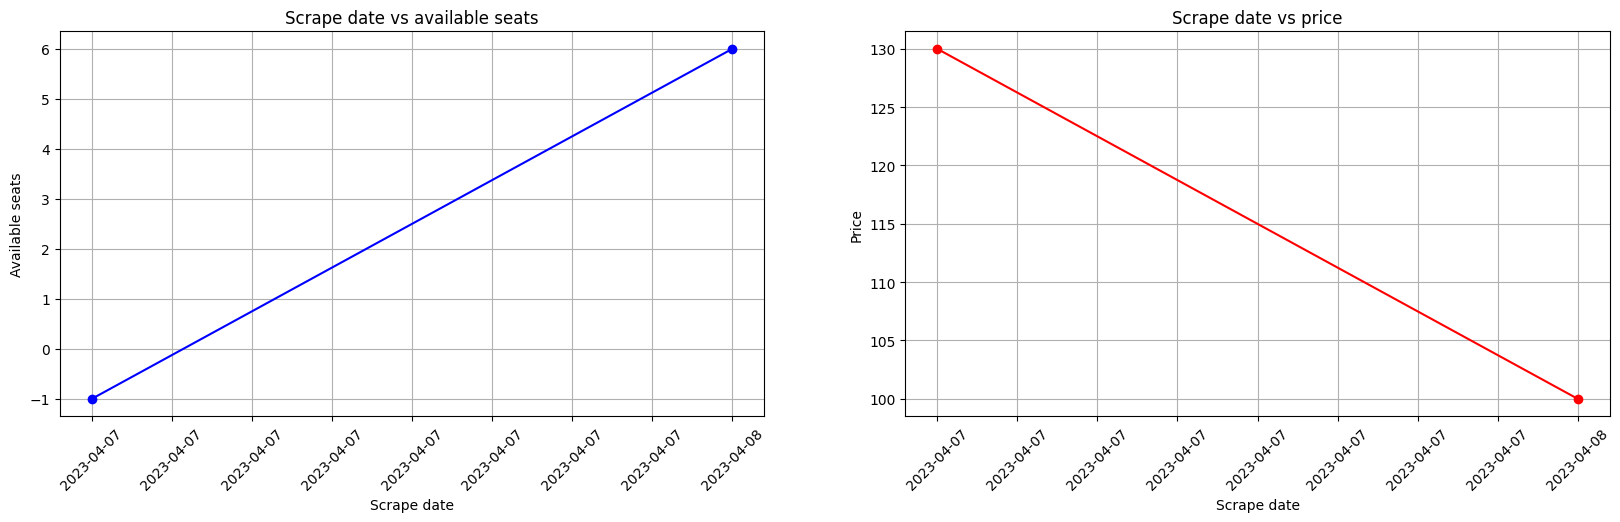

TB_ANR_ALC_2023-04-09_TB1101
Departure Date: 2023-04-09


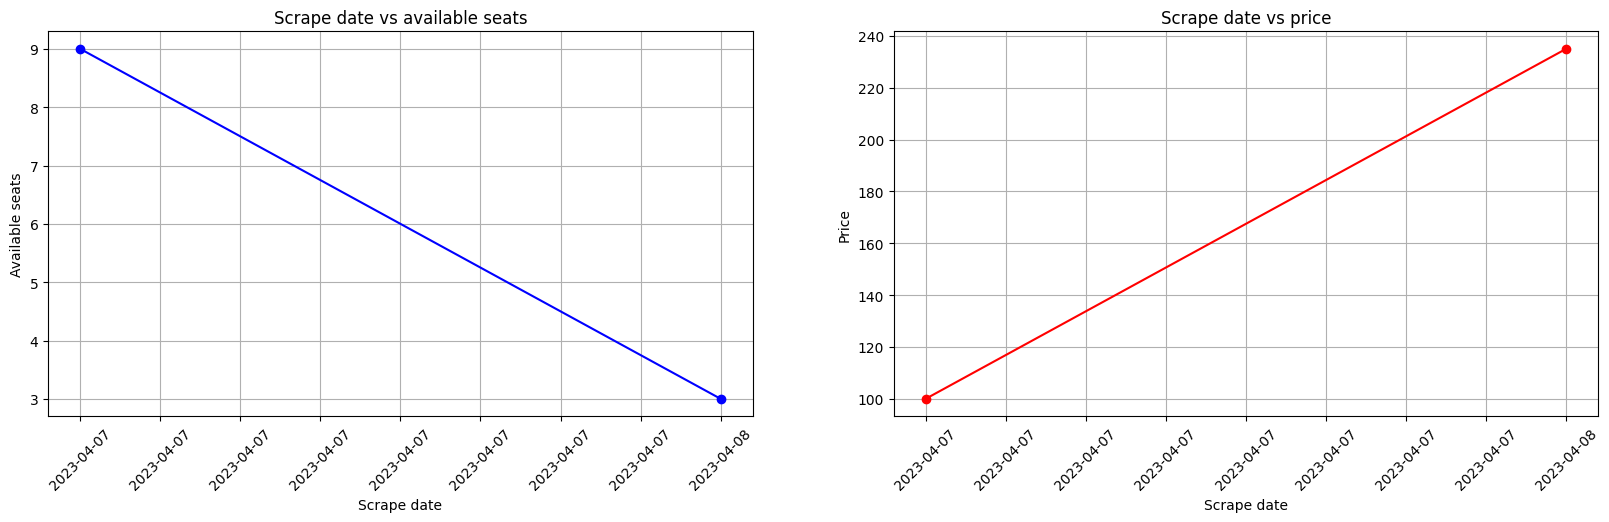

TB_ANR_ALC_2023-04-09_TB1103
Departure Date: 2023-04-09


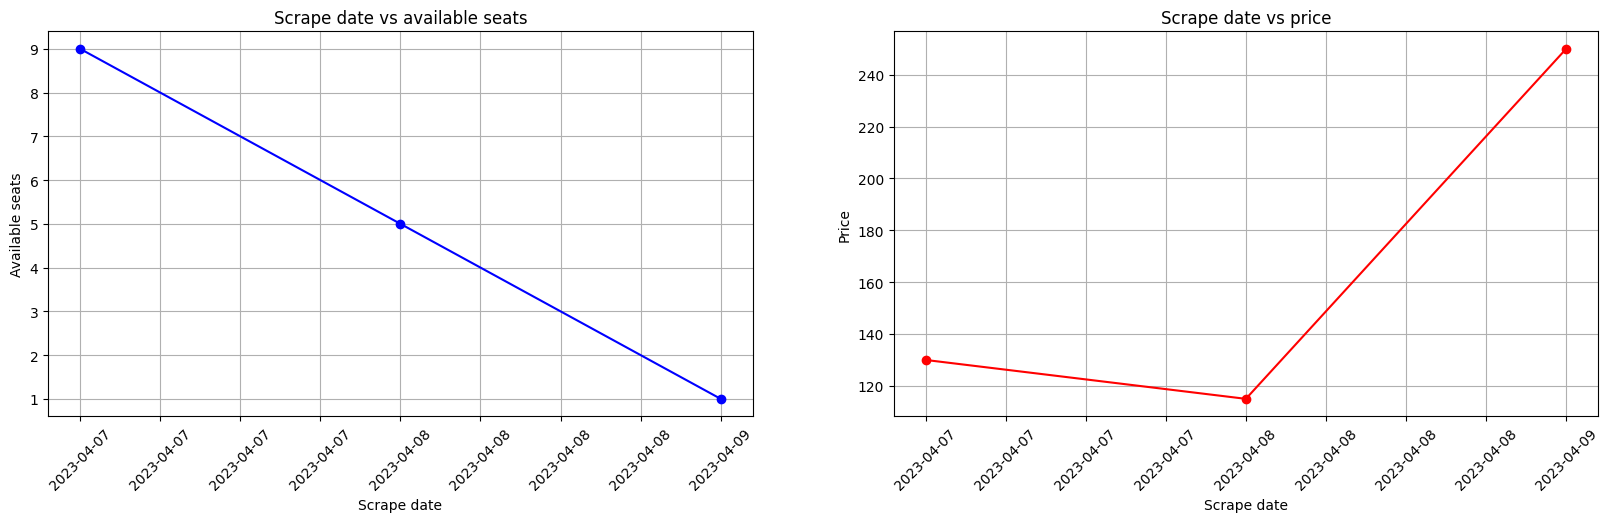

TB_ANR_ALC_2023-04-09_TB1105
Departure Date: 2023-04-09


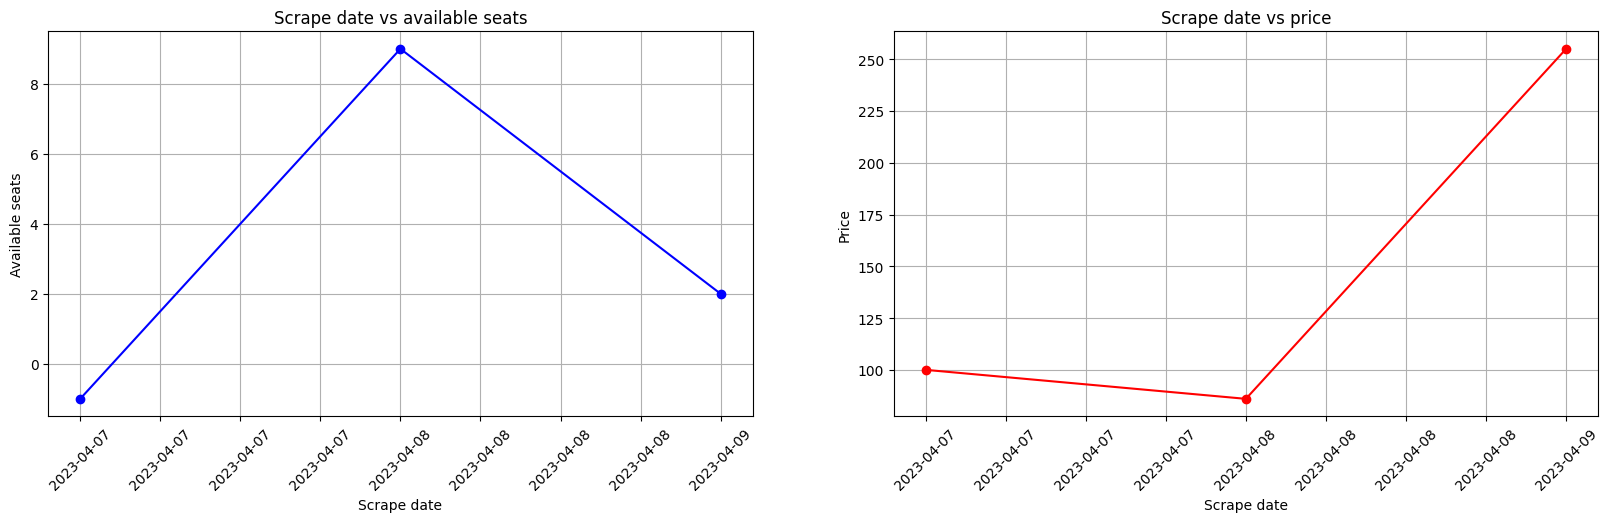

TB_BRU_ALC_2023-04-09_TB1113
Departure Date: 2023-04-09


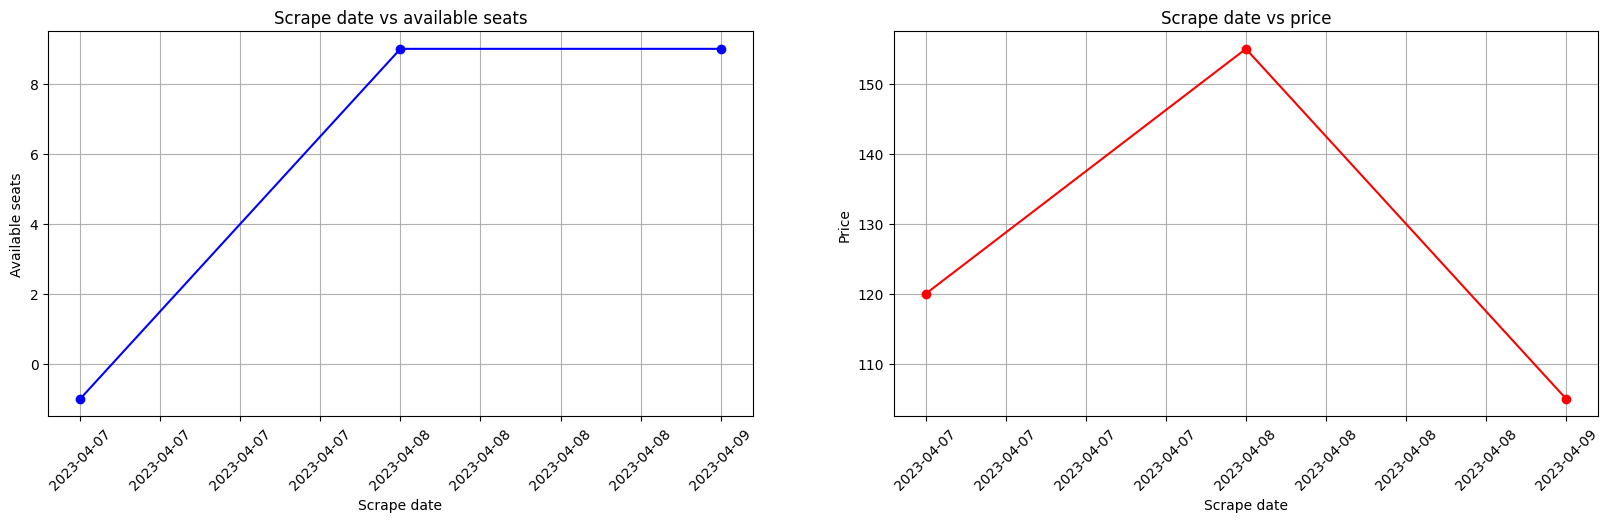

TB_LGG_ALC_2023-04-10_TB1161
Departure Date: 2023-04-10


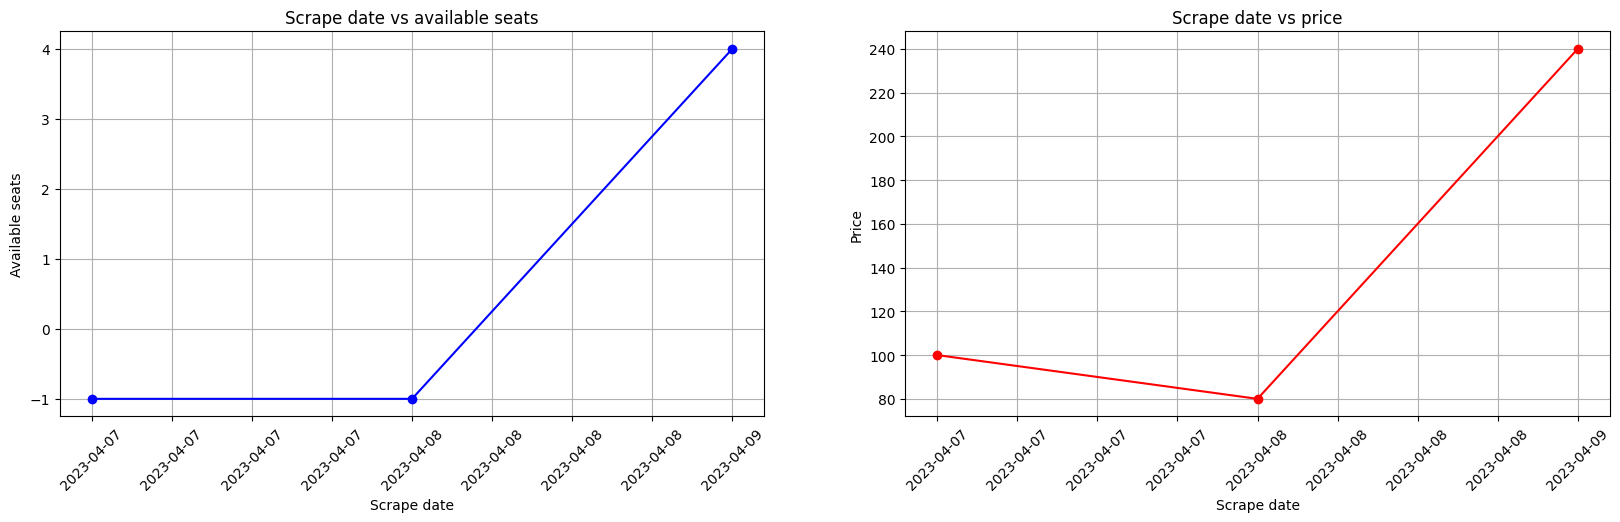

TB_ANR_ALC_2023-04-10_TB1101
Departure Date: 2023-04-10


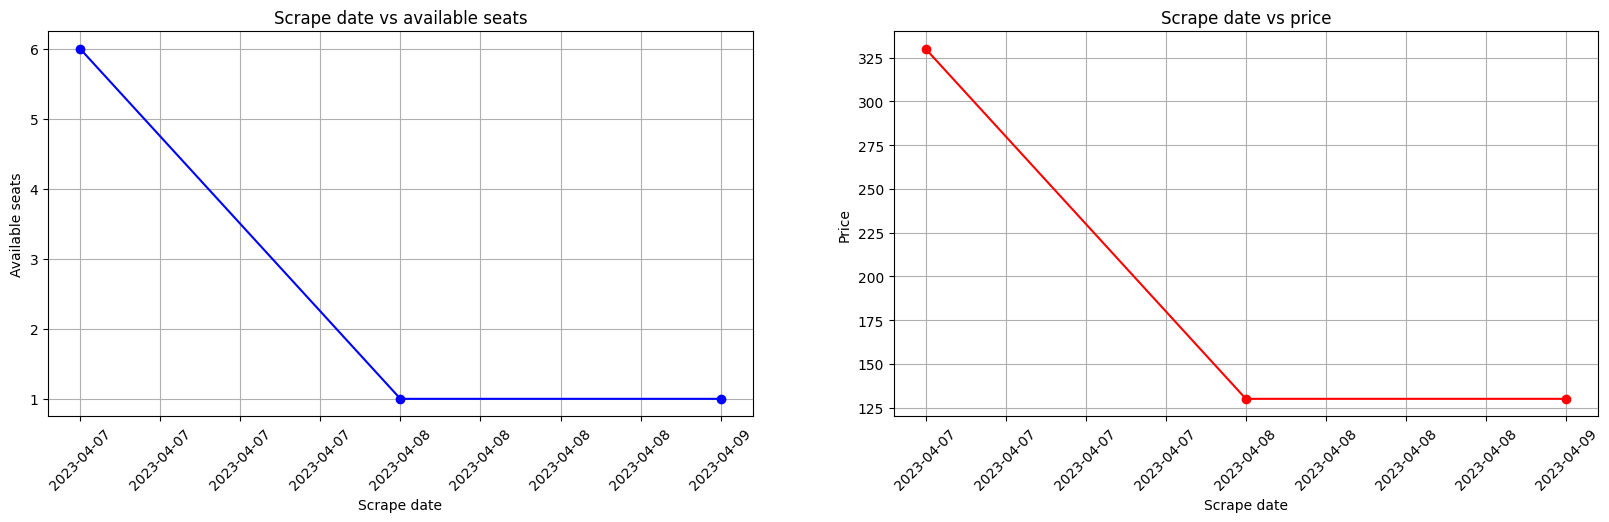

TB_OST_ALC_2023-04-10_TB1171
Departure Date: 2023-04-10


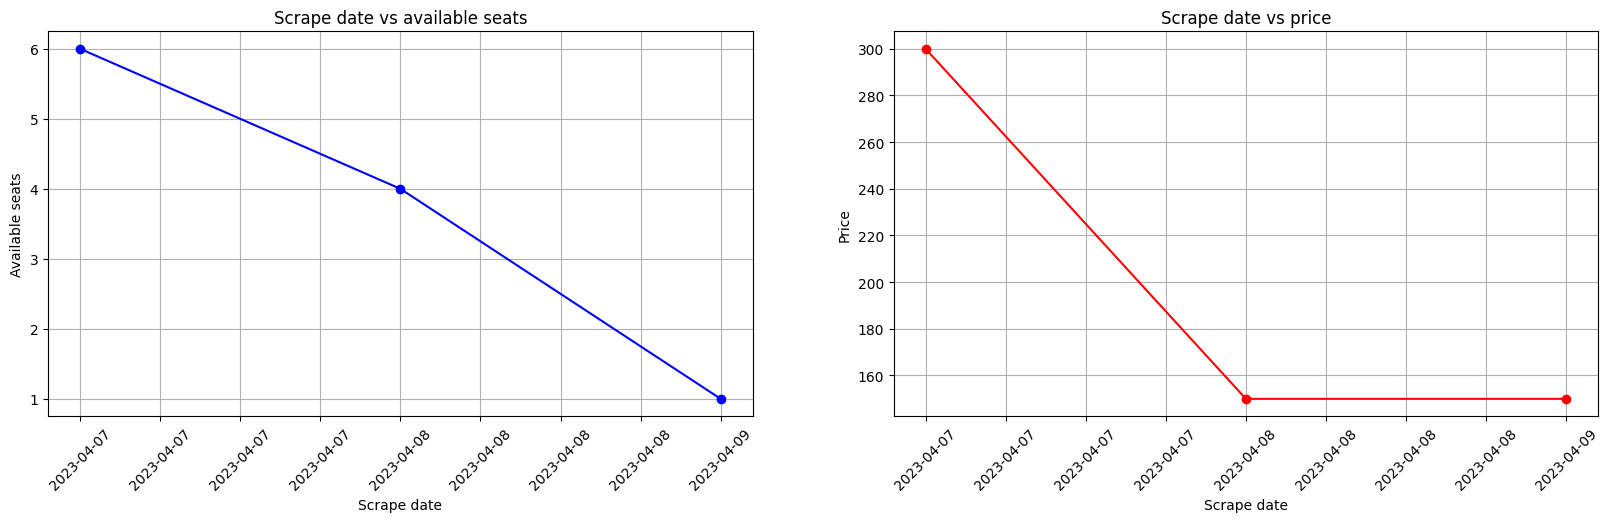

TB_OST_ALC_2023-04-11_TB1171
Departure Date: 2023-04-11


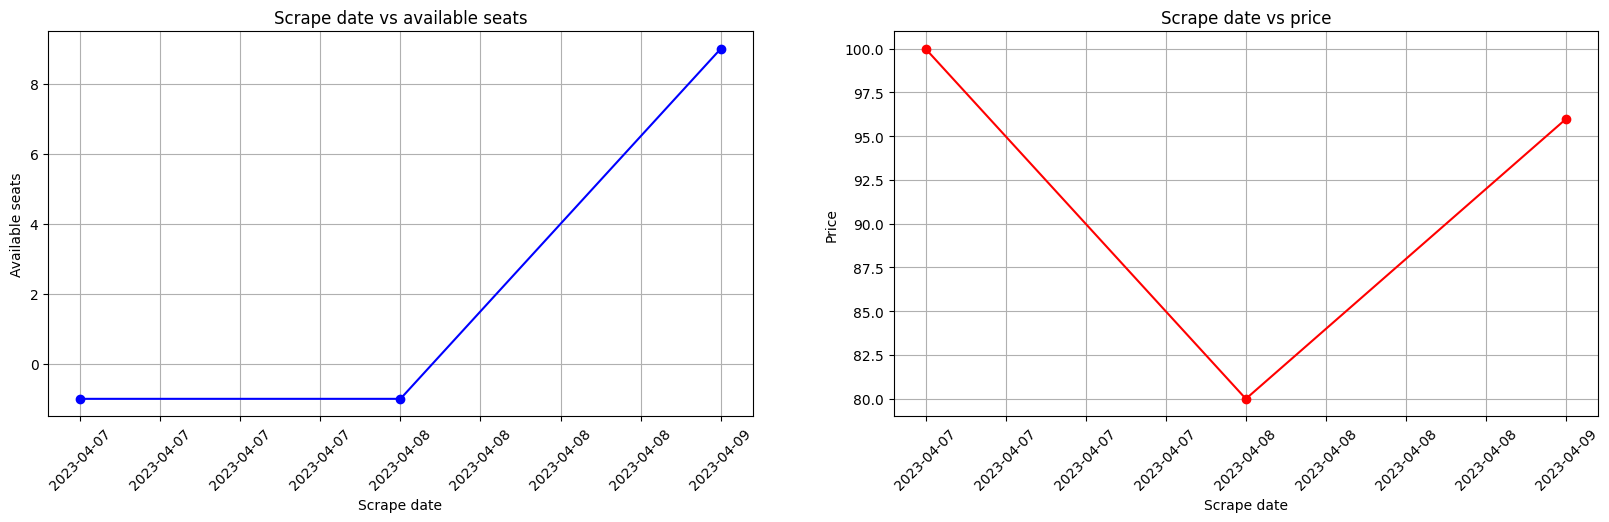

TB_BRU_ALC_2023-04-11_TB1135
Departure Date: 2023-04-11


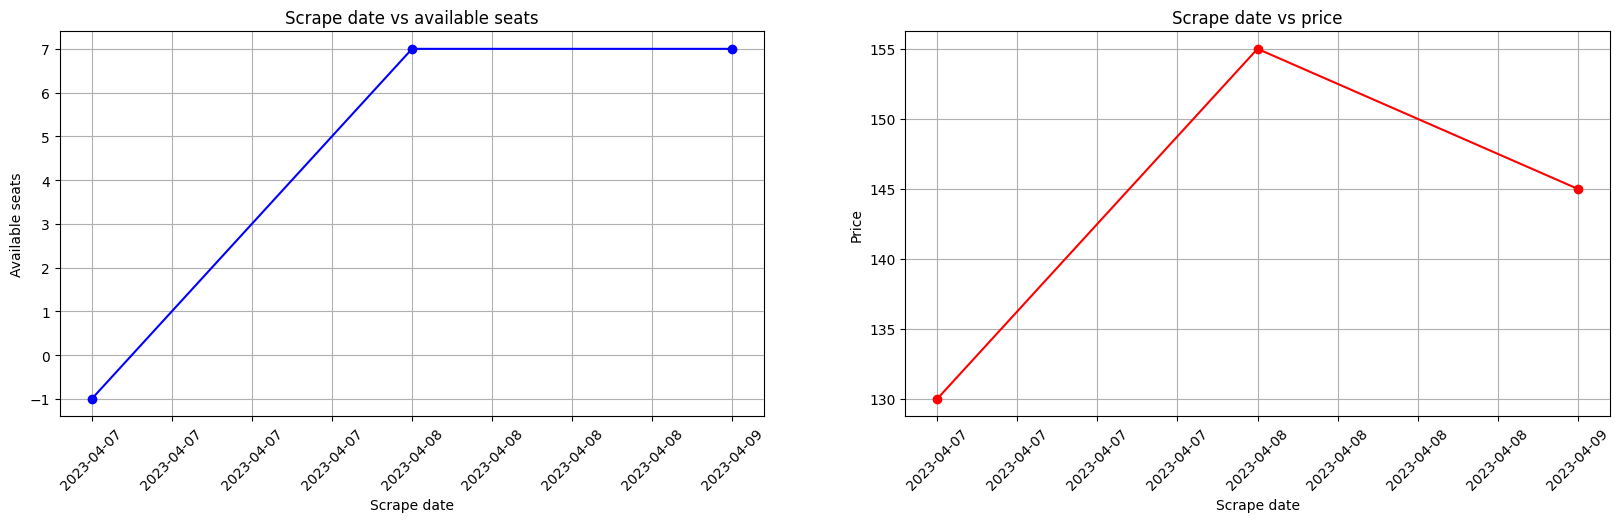

TB_LGG_AGP_2023-04-10_TB1161
Departure Date: 2023-04-10


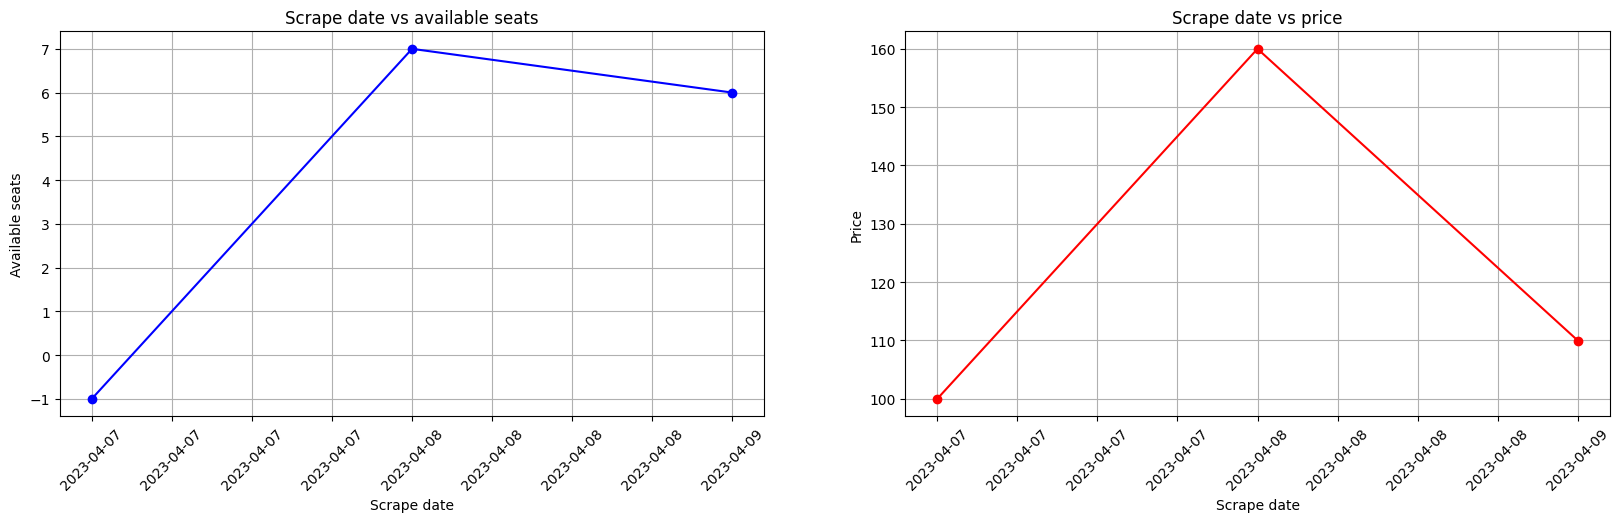

TB_OST_AGP_2023-04-10_TB1071
Departure Date: 2023-04-10


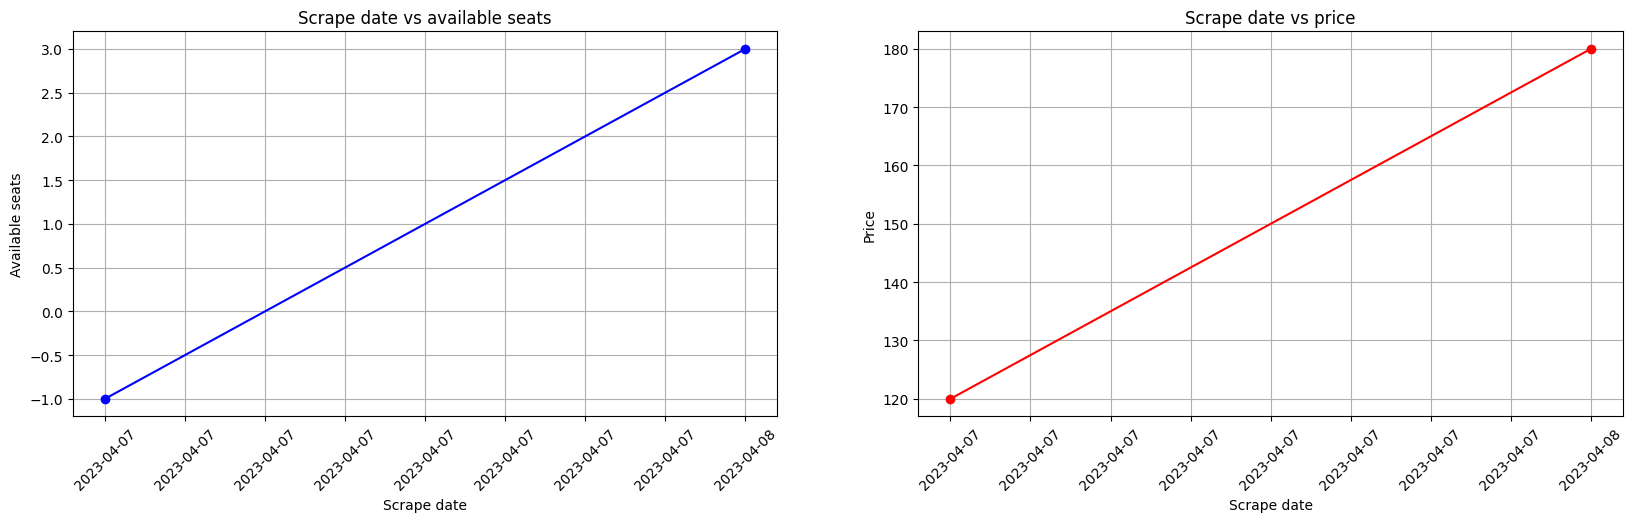

TB_BRU_AGP_2023-04-11_TB1011
Departure Date: 2023-04-11


KeyboardInterrupt: 

In [11]:
def get_flight_data(flight_key):
    flight_data = df_price[df_price['flightKey'] == flight_key]
    flight_data = flight_data.loc[:, ['scrapeDate', 'adultPrice', 'availableSeats']]
    dep_date = get_dep_date_from_key(flight_key)
    flight_data['departureDate'] = dep_date
    flight_data = flight_data.sort_values(by=['scrapeDate', 'departureDate'])
    return flight_data

def get_dep_date_from_key(flight_key):
    date_pattern = r'\d{4}-\d{2}-\d{2}'
    match = re.search(date_pattern, flight_key)
    if match:
        date = match.group()
        return date

unique_flight_keys = df_price['flightKey'].unique()

for i in unique_flight_keys:
    df = get_flight_data(i)
    df = df.sort_values(by=['departureDate', 'scrapeDate'])
    df = df.reset_index(drop=True)
    df = df.set_index('departureDate')
    df['scrapeDate'] = pd.to_datetime(df['scrapeDate'])

    if len(df) > 1 and (df['availableSeats'] != -1).any():

        print(i)

        for j in df.index.unique():

            print(f"Departure Date: {j}")

            fig, ax = plt.subplots(1, 2, figsize=(20, 5))

            ax[0].plot_date(df.loc[j]['scrapeDate'], df.loc[j]['availableSeats'], color='blue', linestyle='solid')
            ax[0].set_xlabel('Scrape date')
            ax[0].tick_params(axis='x', rotation=45)
            date_fmt = mdates.DateFormatter('%Y-%m-%d')
            ax[0].xaxis.set_major_formatter(date_fmt)
            ax[0].set_ylabel('Available seats')
            ax[0].set_title(f'Scrape date vs available seats')
            ax[0].grid()

            ax[1].plot_date(df.loc[j]['scrapeDate'], df.loc[j]['adultPrice'], color='red', linestyle='solid')
            ax[1].set_xlabel('Scrape date')
            ax[1].tick_params(axis='x', rotation=45)
            ax[1].xaxis.set_major_formatter(date_fmt)
            ax[1].set_ylabel('Price')
            ax[1].set_title(f'Scrape date vs price')
            ax[1].grid()

            plt.show()

### (14 a.)  Plot het verband tussen de prijs en het aantal dagen voor vertrek voor Ryanair voor de afgelopen maand

In [29]:
df_all = df_price.merge(df_flight, on='flightKey')
df_all['departureDate'] = pd.to_datetime(df_all['departureDate'])
df_all['scrapeDate'] = pd.to_datetime(df_all['scrapeDate'])
df_ryanair = df_all[(df_all['carrierCode'] == 'FR') & (df_all['departureDate'] < '2023-05-01') & (df_all['scrapeDate'] < '2023-05-01')]
df_ryanair = df_ryanair.loc[:, ['flightKey', 'scrapeDate', 'departureDate', 'adultPrice']]
df_ryanair.reset_index(drop=True, inplace=True)
df_ryanair['daysBeforeDeparture'] = (df_ryanair['departureDate'] - df_ryanair['scrapeDate']).dt.days
df_ryanair

flightKey scrapeDate departureDate  adultPrice   
0     TB_OST_ALC_2023-04-09_TB1183 2023-04-07    2023-04-09      149.99  \
1     TB_BRU_ALC_2023-04-09_TB1111 2023-04-07    2023-04-09      129.99   
2     TB_BRU_ALC_2023-04-09_TB1111 2023-04-08    2023-04-09       99.99   
3     TB_ANR_ALC_2023-04-09_TB1101 2023-04-07    2023-04-09       99.99   
4     TB_ANR_ALC_2023-04-09_TB1101 2023-04-08    2023-04-09      234.99   
...                            ...        ...           ...         ...   
2570  TB_LGG_RHO_2023-04-30_TB2365 2023-04-25    2023-04-30      369.99   
2571  TB_LGG_RHO_2023-04-30_TB2365 2023-04-26    2023-04-30      369.99   
2572  TB_BRU_AGP_2023-04-27_TB1021 2023-04-20    2023-04-27      299.99   
2573  TB_BRU_TFS_2023-04-28_TB1751 2023-04-25    2023-04-28      579.99   
2574  TB_BRU_TFS_2023-04-28_TB1751 2023-04-26    2023-04-28      349.99   

      daysBeforeDeparture  
0                       2  
1                       2  
2                       1  
3                       2  
4                       1  
...                   ...  
2570                    5  
2571                    4  
2572                    7  
2573                    3  
2574                    2  

[2575 rows x 5 columns]

In [31]:
import warnings
warnings.filterwarnings('ignore', message='Polyfit may be poorly conditioned')

unique_flightnumbers = df_ryanair['flightKey'].unique()

n_cols = 5
n_rows = int(np.ceil(len(unique_flightnumbers) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))

for flight_num, ax in zip(unique_flightnumbers, axes.flatten()):

    if len(df_ryanair[df_ryanair['flightKey'] == flight_num]) > 2:
        df = df_ryanair[df_ryanair['flightKey'] == flight_num]
        ax.scatter(df['daysBeforeDeparture'], df['adultPrice'], color='red', s=10)
        ax.set_xlim(ax.get_xlim()[::-1])
        
        z = np.polyfit(df['daysBeforeDeparture'], df['adultPrice'], 4)
        p = np.poly1d(z)
        ax.plot(df['daysBeforeDeparture'], p(df['daysBeforeDeparture']), color='blue')

        ax.set_xticks(np.arange(df['daysBeforeDeparture'].min(), df['daysBeforeDeparture'].max() + 1, 1))
        ax.set_xticklabels(np.arange(df['daysBeforeDeparture'].min(), df['daysBeforeDeparture'].max() + 1, 1), rotation=45)
        ax.set_xlabel('Days before departure')
        ax.set_ylabel('Price')
        ax.set_title(flight_num)
        ax.grid()
        
fig.tight_layout()


### (14 b.) Maak gebruik van regressie om de prijzen te voorspellen voor de volgende maand

In [52]:
df_all = df_price.merge(df_flight, on='flightKey')
df_all['departureDate'] = pd.to_datetime(df_all['departureDate'])
df_all['scrapeDate'] = pd.to_datetime(df_all['scrapeDate'])
df_ryanair = df_all[(df_all['carrierCode'] == 'FR') & (df_all['departureDate'] < '2023-05-01') & (df_all['scrapeDate'] < '2023-05-01')]
df_ryanair = df_ryanair.loc[:, ['flightKey', 'scrapeDate', 'departureDate', 'adultPrice']]
df_ryanair.reset_index(drop=True, inplace=True)
df_ryanair['daysBeforeDeparture'] = (df_ryanair['departureDate'] - df_ryanair['scrapeDate']).dt.days
df_ryanair

flightKey scrapeDate departureDate  adultPrice   
0     FR_CRL_HER_2023-04-08_FR7986 2023-04-07    2023-04-08      205.75  \
1     FR_CRL_PMO_2023-04-08_FR6269 2023-04-07    2023-04-08      129.38   
2     FR_CRL_ALC_2023-04-08_FR3534 2023-04-07    2023-04-08      255.39   
3     FR_CRL_CFU_2023-04-09_FR6251 2023-04-07    2023-04-09      108.59   
4     FR_CRL_CFU_2023-04-09_FR6251 2023-04-08    2023-04-09      108.59   
...                            ...        ...           ...         ...   
2301  FR_BRU_AGP_2023-04-30_FR2923 2023-04-22    2023-04-30      360.42   
2302  FR_BRU_AGP_2023-04-30_FR2923 2023-04-23    2023-04-30      317.72   
2303  FR_BRU_AGP_2023-04-30_FR2923 2023-04-24    2023-04-30      309.30   
2304  FR_BRU_AGP_2023-04-30_FR2923 2023-04-25    2023-04-30      354.32   
2305  FR_BRU_AGP_2023-04-30_FR2923 2023-04-26    2023-04-30      354.32   

      daysBeforeDeparture  
0                       1  
1                       1  
2                       1  
3                       2  
4                       1  
...                   ...  
2301                    8  
2302                    7  
2303                    6  
2304                    5  
2305                    4  

[2306 rows x 5 columns]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

param_grid = {
    'n_estimators': [300, 350, 400, 450, 500],
    'max_depth': [1, 2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3, 4]
}

gscv = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)

df_ryanair = df_ryanair.drop(['flightKey'], axis=1)

# turn date into float
df_ryanair['departureDate'] = df_ryanair['departureDate'].astype('int64') / 10**9
df_ryanair['scrapeDate'] = df_ryanair['scrapeDate'].astype('int64') / 10**9

X = df_ryanair.drop(['adultPrice'], axis=1)
y = df_ryanair['adultPrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gscv.fit(X_train, y_train)

gscv.best_params_

In [54]:
rfr = gscv.best_estimator_

rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_test, y_pred))

df_ryanair['predictedPrice'] = rfr.predict(X)
df_ryanair

scrapeDate  departureDate  adultPrice  daysBeforeDeparture   
0     1.680826e+09   1.680912e+09      205.75                    1  \
1     1.680826e+09   1.680912e+09      129.38                    1   
2     1.680826e+09   1.680912e+09      255.39                    1   
3     1.680826e+09   1.680998e+09      108.59                    2   
4     1.680912e+09   1.680998e+09      108.59                    1   
...            ...            ...         ...                  ...   
2301  1.682122e+09   1.682813e+09      360.42                    8   
2302  1.682208e+09   1.682813e+09      317.72                    7   
2303  1.682294e+09   1.682813e+09      309.30                    6   
2304  1.682381e+09   1.682813e+09      354.32                    5   
2305  1.682467e+09   1.682813e+09      354.32                    4   

      predictedPrice  
0         181.545407  
1         181.545407  
2         181.545407  
3         157.747536  
4         172.570789  
...              ...  
2301      289.205720  
2302      300.719259  
2303      298.762766  
2304      318.606283  
2305      368.161194  

[2306 rows x 5 columns]